# **- Lesson 1 -**
# **Shortest Path (Dijkstra's) algorithm applied in OSM driving network of the Helsinki Region**

![map1](img/output-map1.png)

## **Introduction**
In this Lesson 1, we are going to process the *Shortest Path* between every buildings registered in OpenStreetMap (OSM) to the Rautatieasemaa. This practice gives an overview about the *accessibility* of the population to the Helsinki city center considering the central railway station as the central point. The *Dijkstra's algorithm* can be applied in the OSM driving network using the Python library OSMNX which operates network analysis under the hood using NetworkX. The newest version of OSMNX implements *Core Parallelization* so we can operates the routing in parallel in your available cores.

## **Datasets**
Both datasets are fetched during the workflow from OSM using the OSMNX and they are:

- Buildings footprint in the Helsinki Region or Uusimaa Administrative Unit (if you want to escalate the process)
- Central railway station - Rautatieasemaa

## **Output**
The process gives as output a layer with 19 070 routes from every buildings in the Helsinki Region to the Rautatieasemaa

## **Objective**
To compare the advantage of processin time of *Shortest Path* algorithm in the Helsinki Region using parallel computing in a 16-core machine

## **Resources**

CSC Machine-Puhti:

- *Partition*: small
- *CPU Cores*: 16
- *Memory (GB)*: 60
- *Local Disk (GB)*: 120


## **Processing**
Follow the next steps and run every cell with more than 1 core available.

### **- Import Python libraries -**

Be sure that you have installed the OSMNX>=1.6.0 in your environment. Get familiar with this library reading a bit the [OSMNX Documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html)

In [4]:
import os
import glob
# os.environ['USE_PYGEOS'] = '0'

# for (geospatial) analysis
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiLineString
from shapely import ops
import osmnx as ox

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# for optimization of computational resources
from joblib import Memory, Parallel, delayed
import multiprocessing as mp

# time processing
import time
import warnings
warnings.filterwarnings('ignore')

We are going to create a folder `output` where the results are going to be stored

In [5]:
# results folder
if not os.path.exists('output'):
    os.makedirs('output')

### **- Fetch OSM buildings -**

To fetch OSM features you need to define an area like the Helsinki Region and the feature tag like buldings. You can find each one in the next links:

- For OSM areas: [*Nominatim*](https://nominatim.openstreetmap.org/ui/search.html?q=%27Capital+region%2C+Mainland+Finland%2C+Finland%27)
- For feature tags: [*OSM Wiki*](https://wiki.openstreetmap.org/wiki/Buildings)

To fetch the elements from the wanter area we use the osmnx function `features_from_place()`

In [6]:
# ------> Fetch residential buildings

place_name = 'Capital region, Mainland Finland, Finland'
# place_name = 'Uusimaa, Southern Finland, Mainland Finland, Finland' ---> if you want to escalate 

# Tags for residential buildings
tags = {'building': 'residential'}

# run
all_buildings = ox.features_from_place(place_name, tags)

Once you have fetched the buildings you will see that it contains double index and many columns. We will simplify this to have a more kneat frame of the data simple by deleting the indexes and keeping only the `street name` and the `geometry`.

In [7]:
# ------> Reset index and get street name

all_buildings = all_buildings.reset_index(drop=False)
all_buildings = all_buildings[['osmid', 'addr:street', 'geometry']]

# rename
all_buildings = all_buildings.rename(columns={'addr:street':'street_name'})

The geometry of the buildings are represented by **points** and **polygons**. What we need to have is only points because the *Shortest Path* analysis runs between two points (longitude and latitude) so we will add the `centroid` of every geometry to remove the polygons and keep them as centroids.

In [8]:
# fix geometries
all_buildings['geometry'] = [geom.centroid for geom in all_buildings['geometry']]

Here is a quick view of the buildings data.

In [9]:
all_buildings.head()

osmid    street_name                   geometry
0   541819596        Kivitie  POINT (24.71583 60.16658)
1   930663425       Marjatie  POINT (24.98284 60.25331)
2  4344538322     Marsinkuja  POINT (25.09871 60.34180)
3  7431146450      Kirjomäki  POINT (24.70024 60.19842)
4  9937667073  Siriuksenkuja  POINT (25.08450 60.34347)

The library `geopandas` for spatial analysis contains a function `explore()` that allows you to visualize data in a quick and interactive way. We will add some keywords to modify a bit our visualization

In [10]:
print(f'Total residential buildings: {len(all_buildings)}')
all_buildings.explore(color='red', marker_kwds={'radius':0.4})

Total residential buildings: 19070


### **- Define Origins as a List -**

A particularity of the *Shortest Path* function in OSMNX is that you can process A-Origin to A-Destination. Also, you can process pair routes as Lists in a way that `[A-Origin, B-Origin, C-Origin, ...]` to `[A-Destination, B-Destination, C-Destination, ...]`.

Based on this feature of the OSMNX library we are going to start organizing a List `all_origins` that contains *geometry* objects of every building we have fetched from OSM in the Helsinki Region.

In [11]:
# --------> define origin List

# list
all_origins = []

for row in all_buildings.itertuples(index=True):
        
    # tuple, only geometries
    geom = row.geometry
    
    all_origins.append(geom)

In [12]:
all_origins[:10]

[<POINT (24.716 60.167)>,
 <POINT (24.983 60.253)>,
 <POINT (25.099 60.342)>,
 <POINT (24.7 60.198)>,
 <POINT (25.084 60.343)>,
 <POINT (24.837 60.191)>,
 <POINT (25.036 60.205)>,
 <POINT (25.036 60.205)>,
 <POINT (25.036 60.205)>,
 <POINT (25.027 60.19)>]

### **- Fetching road network -**

In this step we are going to fetch the *Graph* object containing the edges (roads) and nodes (interections) of the OSM driving network. The function that we will use is the `graph_from_place()` from OSMNX.

#### *Note!*

We are going to create a function that packs the OSMNX function. The objective is to add it to `cache` memory.

The library `joblib` is able to cache processed that can be repetitive and optimize the processing in a workflow. This means, that the first time you fetch the *Graph* from OSM will take some time, but the next times will be **inmediate** because the process is cached.

In [ ]:
def graph_Helsinki(place_name, network_type='drive'):
    '''
    Packed function for repetitive running and testing
    
    - place_name: string, area from OSM 
    - network_type: string, type of OSM network from drive, bike, walk
    
        return <Function>
    '''
    
    return ox.graph_from_place(place_name, network_type)

Cache the *Graph* fetch

In [14]:
# cache
memory = Memory('cache', verbose=0)
graph_Helsinki_cached = memory.cache(graph_Helsinki)

In [15]:
%%time

# get the road network as graph object
graph = graph_Helsinki_cached(place_name, network_type='drive')

CPU times: user 2.29 s, sys: 54.2 ms, total: 2.34 s
Wall time: 2.56 s


The OSMNX function can plot the graph using the `plot_graph()` function. We added some modifications to have a clean view.

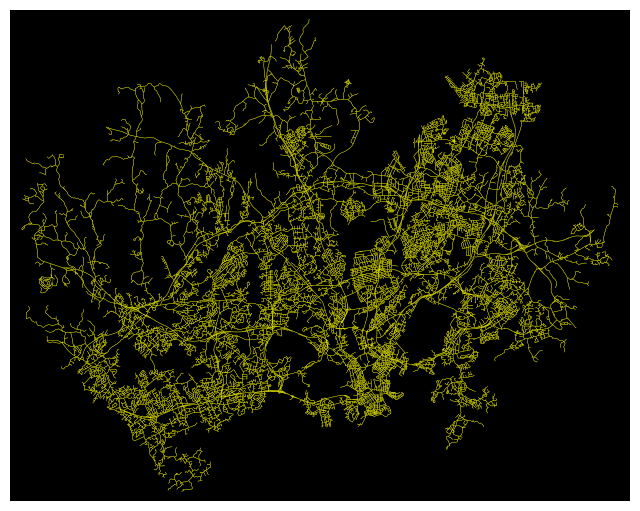

In [16]:
fig, ax = ox.plot_graph(graph, node_size=0, edge_linewidth=0.2, edge_color='yellow', bgcolor='black')

### **- Rautatieasemaa geometry as a Destination -**

We are going to fetch the location of *Rautatieasemaa** from OSM stations. What we need is to get the *geometry* object and we will do it as simple as possible.

Simply, we create a function that fetch the location and return the *geometry* directly.

In [ ]:
def get_Rauratientori_gdf():
    '''
    Give back Rautatori Point geometry in WGS84 from OSM
        Return Point geometry 
    '''
    
    # Fetch train stations
    place_name = 'Capital region, Mainland Finland, Finland'

    # Tags for train station
    tags = {'railway': 'station'}

    # run
    all_stations = ox.features_from_place(place_name, tags)
    
    # reset index and remove subways
    all_stations = all_stations.reset_index(drop=False)
    all_stations = all_stations[['name', 'geometry']]
    
    # get Rautatieasemaa
    Rautatientori = all_stations.loc[all_stations.name=='Helsinki']
    
    return (Rautatientori.geometry[0])

In [ ]:
# Rautatientori geom as destination

destin_geom = get_Rauratientori_gdf()

### **- Calculate Shortest Path using Parallelization (16 Core) -**

We are goin to run step by step the process of finding the *Shortest Path*. Also, you will see that some steps are parallelized in the available cores.

The advantage we have separating the workflow is that we are able to run in parallel and it saves time processing

#### ***About the Core Parallelization***

To start understanding a bit more the parallel computing let's take a look the available resources in our machine using the next command.


In [ ]:
!lscpu | egrep 'Model name|Socket|Thread|NUMA|CPU\(s\)'

We can see the number of Cores available in the **CPU(s)** sections. The partition contains in total 40 Cores but the configuration we specified at the beginning in the machine was 16 Cores. So? Despite 40 cores are available only 16 cores are *reserved* for our analysis.

We can monitor our processes and the Core utilization with `htop` library that let us visuallize dinamically how the computer is using the resources. If you are willing to monitor your process you should open in a new command line `$ htop` (be sure you are using your own environment)

Let's take a look at the resources utilization after each process.

#### **A. Find the Closest Nodes**

The *Shortest Path* is operated in the OSM network between nodes (interections) so the Origin and Destination location are simply a reference that helps to find the closest node where the routing should start.

In the next cells we are going to find the closest nodes using the function `nearest_nodes()` from OSMNX.

The destination and only one geometry of Rautatieasemaa we computeed only 1 nearest node. Additiionally, the process of finding the closest note of every origin was parellized using the library `multiprocess`.

We are going to start measuring the processing time using simple time variables at the beginning and end of the cell and we will sum up at the end to compare how the efficiency improves using parallel computation.

##### **Destination node**


In [ ]:
s = time.time()

# ---- A1) Closest destination node

closest_target_node = ox.nearest_nodes(G=graph, 
                                       X=destin_geom.x, 
                                       Y=destin_geom.y)


# --------------------------------------------------------
d1 = time.time() - s
print(f' - Closest destination node: {d1} seconds')

If you can monitor the processes using `htop` (optional) you will see that we have in total 40 Cores. Some of them are already in use but there are still 16 Cores available for our use. 

This is how the resource utilization looks if you are running the *Destination node* cell

![htop1](img/machine-core-1.png)

As we are running a common process the computer is using a single node: the Core #30. 

##### **Origins nodes**

We have 19 070 origins that we should compute and find the closest node. To optimize the time processing we are going to parallelize for every origin.

We will use the Python library `multiprocess` to parallelize the closest node process of the origins. Let's start packing the function `nearest_nodes()` from OSMNX.

In [ ]:
print(f'- Processing total routes: {len(all_origins)}')

In [ ]:
def get_nearest_node(graph, geom):
    '''
    Packed function to return a closest node from geometry
    
    - graph: graph, osm object
    - origin_geom: point geom, individual
    
        return:: int, a node code
    '''
    
    # calculate node
    node = ox.nearest_nodes(G=graph, X=geom.x, Y=geom.y) 
    
    return node

The `multiprocess` library is able to send a job to every core and optimize the workflows. The step is simple once we have packed the function we are going to use in this case `get_nearest_node()`

##### *Note*
As a condition, you should be able to loop over the inputs otherwise the process is not going to be parallelized. We are looping over every origin so we can distribute the process in every core.

The variables involved in the parallelization are:

- `cpus`: the number of cores available for computation with `cpu_count()`
- `args`: the parameters of our packed function, looping over every input
- `pool`: a pool opened for every available core where that *asyncronize* the process with `starmap_async()`
- `get()`: catch the result of every process in every core and save in a list

Then, you to close the pool you `close()` and `join()`.

In [ ]:
s = time.time()

# ----- A2) Closest origins node

# get cores
cpus = mp.cpu_count()

# ----- args

args = ((graph, geom) for geom in all_origins)

# ----- pool - with function

pool = mp.Pool(cpus)
sma = pool.starmap_async(get_nearest_node, args)

# ----- get list of results

closest_origin_node_list = sma.get()
pool.close()
pool.join()


# ----------------------------------------------------------
d2_parallel = time.time() - s
print(f' - Closest node of origins [PARALLELIZED]: {d2_parallel/60} minutes')

If you monitor the process in `htop` you see notice how the resource utilization changed.

At first you will see how the Cores start to be used:

![htop2](img/machine-core-starting.png)

Finally, it will occupy the 16 Cores available: 

![htop1](img/machine-core-16.png)

In total 16 Cores: from Core #20 to Core #35 

#### **B. Calculating the Shortest Path**

To continue...

In [17]:
def compute_shortest_path(graph, closest_origin_node, closest_target_node): 
    '''
    Function to test computing as cache
    - graph is osm object
    - closest_origin_node:: osm object
    - closest_target_node:: osm onject
        return nodes path list
    '''
    
    route = ox.shortest_path(graph, 
                             orig=closest_origin_node, 
                             dest=closest_target_node, 
                             weight='length')
    return route



def nodes_to_path(graph, route_nodes):
    '''
    Simple function to send it to parallelization and get path from nodes
    - graph: osm graph object
    - route_nodes: list of nodes of path
    '''
    
    # get route from nodes
    shortest_route_parallel = ox.utils_graph.route_to_gdf(graph, route_nodes, weight='length')[['length', 'geometry']].reset_index(drop=True)
    
    # join the road segments
    multi_line = MultiLineString([linegeom for linegeom in shortest_route_parallel.geometry])    
    total_length = sum([value for value in shortest_route_parallel['length']])
    
    merged_line = ops.linemerge(multi_line)
    
    # new gdf
    shortest_route_merged = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=4326)
    shortest_route_merged.at[0, 'geometry'] = merged_line
    shortest_route_merged.at[0, 'length'] = total_length
        
    return shortest_route_merged

def compute_distance(shortest_path_gdf):
    '''
    Compute distance in FinCRS EPSG:3387
    
    '''
    
    # project WGS84 to EPSG3387
    distances = shortest_path_gdf.to_crs("EPSG:3387").geometry.length
    
    # add
    shortest_path_gdf['distance_fincrs'] = distances
    
    return shortest_path_gdf
    
    

### 4.1) Shortest path - 16 Core

In [24]:
s = time.time()

# ---- target nodes should be same length as origins

closest_target_node_list = [closest_target_node] * len(closest_origin_node_list)

# --------4) Shortest Path ---------

# run
routes = ox.shortest_path(graph, 
                         orig = closest_origin_node_list, 
                         dest = closest_target_node_list, 
                         weight = 'length',
                         cpus = None) # none takes all cores, default=1


# --------------------------------------------------------------------------

d4 = time.time() - s
print(f' - Shortest Path run [PARALLELIZED]: {d4/60} minutes')

 - Shortest Path run [PARALLELIZED]: 2.8810895800590517 minutes


In [25]:
# remove None values from invalid routes
all_routes = [value for value in routes if value != None]

# check routes length
len(all_routes)

19070

### 5) Nodes to Path and compute distance - 16 CORE -

Distance is computed in Finnish CRS EPSG 3067

In [35]:
s = time.time()

# --------- 5) Get path as geom GDF

# get cores
cpus = mp.cpu_count()

# ----- args

args = ((graph, route_nodes) for route_nodes in all_routes)

# ----- pool - with function

pool = mp.Pool(cpus)
sma = pool.starmap_async(nodes_to_path, args)

# ----- get list of results - GDF

shortest_path_gdf_list = sma.get()
pool.close()
pool.join()

# --------------------------------------------------------------------------

d5 = time.time() - s

In [36]:
# ------  create a single GDF

all_routes_gdf = pd.concat(shortest_path_gdf_list)  
    
# ----- Compute distance EPSG FIN

route_distance_gdf = compute_distance(all_routes_gdf)

In [38]:
print(f' - Nodes to path and distances: {d5/60} minutes')

 - Nodes to path and distances: 2.7900312145551047 minutes


### Results

In [40]:
print(f' - In total {len(all_routes_gdf)} routes processed using 16 cores\n')

route_distance_gdf.head()

 - In total 19070 routes processed using 16 cores



geometry     length  \
0  LINESTRING (24.71545 60.16585, 24.71563 60.165...  14223.070   
0  LINESTRING (24.98252 60.25363, 24.98266 60.253...  11398.613   
0  LINESTRING (25.09719 60.34168, 25.09722 60.341...  24002.260   
0  LINESTRING (24.70108 60.19757, 24.70096 60.197...  16903.543   
0  LINESTRING (25.08414 60.34351, 25.08592 60.342...  24620.528   

   distance_fincrs  
0     14307.087156  
0     11454.487551  
0     24118.724409  
0     16999.833987  
0     24742.146196

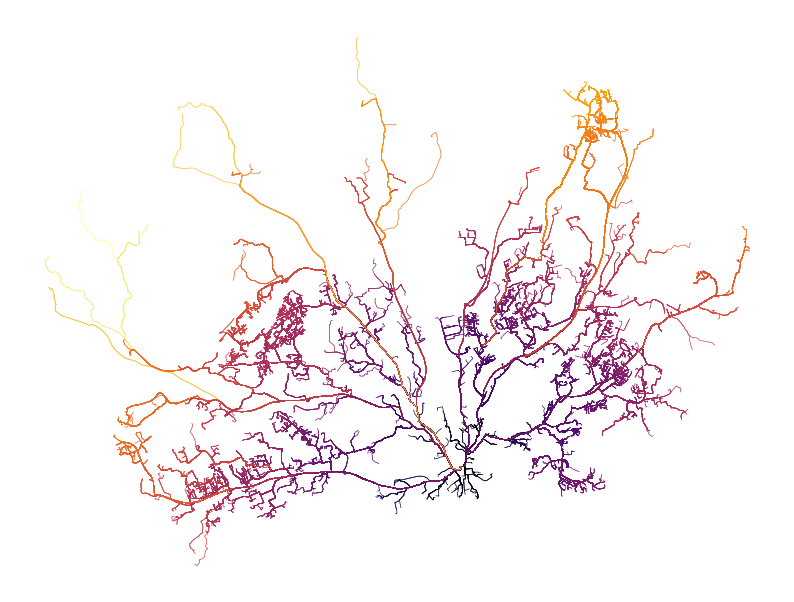

In [42]:
ax = all_routes_gdf.plot(figsize=(10, 8), 
                         column='distance_fincrs', 
                         linewidth=0.5, 
                         cmap='inferno', 
                         alpha=1
                        );

ax.axis(False);

plt.savefig('output/shortest_path_parallel_16_core.png', dpi=300)

In [43]:
s = time.time()

# -------- Save

filepath = 'output/shortest_path_parallel_16_core.gpkg'
all_routes_gdf.to_file(filepath, index=False)

# --------------------------------------------------------------------------

d6 = time.time() - s
print(f' - Saving time: {d6} seconds')

 - Saving time: 9.701611995697021 seconds


###   ______ 1 core  ______

### 3.2) Closest origins node - 1 Core

In [44]:
s = time.time()

# ----- 3) Closest origins node

closest_origin_node_list = [ox.nearest_nodes(G=graph, 
                                           X=origin_geom.x, 
                                           Y=origin_geom.y) 
                               for origin_geom in all_origins]
    
# ----------------------------------------------------------

d3_non = time.time() - s

print(f' - Closest node of origins [NON-PARALLELIZED]: {d3_non/60} minutes')

 - Closest node of origins [NON-PARALLELIZED]: 58.21728078921636 minutes


### 4.2) Shortest path - 1 Core

In [45]:
s = time.time()

# ---- target nodes should be same length as origins

closest_target_node_list = [closest_target_node] * len(closest_origin_node_list)

# --------4) Shortest Path ---------

# run
routes = ox.shortest_path(graph, 
                         orig = closest_origin_node_list, 
                         dest = closest_target_node_list, 
                         weight = 'length',
                         cpus = 1)


# --------------------------------------------------------------------------

d4_non = time.time() - s
print(f' - Shortest Path run [NON-PARALLELIZED]: {d4_non/60} minutes')

 - Shortest Path run [NON-PARALLELIZED]: 21.750111134847007 minutes


In [46]:
# remove None values from invalid routes
all_routes = [value for value in routes if value != None]

# check routes length
len(all_routes)

19070

### 5) Nodes to Path and compute distance - 1 CORE

Distance is computed in Finnish CRS EPSG 3067

In [48]:
s = time.time()

# --------- 5) Get path as geom GDF

all_routes_gdf = gpd.GeoDataFrame()

for each_route in routes:
        
    # ----- create nodes path to GDF
    
    route_gdf = nodes_to_path(graph, each_route)
    
    # ----- Compute distance

    route_distance_gdf = compute_distance(route_gdf)
    
    all_routes_gdf = pd.concat([all_routes_gdf, route_distance_gdf])
    
# --------------------------------------------------------------------------

d5_non = time.time() - s

In [49]:
print(f' - Nodes to path and distances: {d5_non/60} minutes')

 - Nodes to path and distances: 2.7900312145551047 minutes


### Results

In [50]:
print(f' - In total {len(all_routes_gdf)} routes processed with 1 core\n')

all_routes_gdf.head()

 - In total 19070 routes processed with 1 core



geometry     length  \
0  LINESTRING (24.71545 60.16585, 24.71563 60.165...  14223.070   
0  LINESTRING (24.98252 60.25363, 24.98266 60.253...  11398.613   
0  LINESTRING (25.09719 60.34168, 25.09722 60.341...  24002.260   
0  LINESTRING (24.70108 60.19757, 24.70096 60.197...  16903.543   
0  LINESTRING (25.08414 60.34351, 25.08592 60.342...  24620.528   

   distance_fincrs  
0     14307.087156  
0     11454.487551  
0     24118.724409  
0     16999.833987  
0     24742.146196

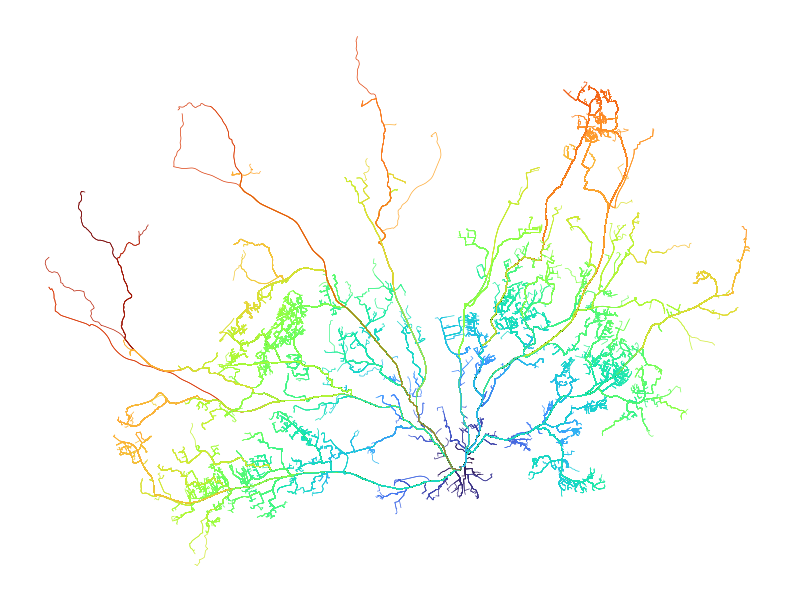

In [63]:
ax = all_routes_gdf.plot(figsize=(10, 8), 
                         column='distance_fincrs', 
                         linewidth=0.5, 
                         cmap='turbo', 
                         alpha=1
                           );

ax.axis(False);

plt.savefig('output/shortest_path_parallel_1_core.png', dpi=300)

#### 6) Saving

In [57]:
s = time.time()

# -------- Save

filepath = 'output/shortest_path_parallel_1_core.gpkg'
all_routes_gdf.to_file(filepath, index=False)

# --------------------------------------------------------------------------

d6_non = time.time() - s
print(f' - Saving time: {d6_non} seconds')

 - Saving time: 9.817084789276123 seconds


## SUMMARY

In [60]:
print(f'------- PROCESSING TIME ------------\n')

total = d1 + d2 + d3 + d4 + d5 + d6

print(f'----- Total time : {round(total/60, 2)} mins -> 16 Core')

total_non = d1 + d2 + d3_non + d4_non + d5_non + d6_non

print(f'----- Total time : {round(total_non/60, 2)} mins -> 1 Core')


------- PROCESSING TIME ------------

----- Total time : 10.56 mins -> 16 Core
----- Total time : 90.44 mins -> 1 Core
